# Extracting keywords in a document

Using TF-IDF <br>
Example2

# 1)- Importing key modules

In [1]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import numpy as np 
import pickle
import pandas as pd 

#For Visuals
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
import seaborn as sns
sns.set(rc={'figure.figsize':(15,9)})
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [3]:
%reload_ext version_information
%version_information pandas,numpy, nltk, seaborn, matplotlib, re

Software versions
Python 3.7.4 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.8.0
OS Darwin 19.0.0 x86_64 i386 64bit
pandas 0.25.1
numpy 1.17.2
nltk 3.4.5
seaborn 0.9.0
matplotlib 3.1.1
re 2.2.1
Tue Dec 17 10:50:14 2019 CET

# 2)- Loading Dataset

In [4]:
data=pd.read_csv('papers.csv')
data.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7241 entries, 0 to 7240
Data columns (total 7 columns):
id            7241 non-null int64
year          7241 non-null int64
title         7241 non-null object
event_type    2422 non-null object
pdf_name      7241 non-null object
abstract      7241 non-null object
paper_text    7241 non-null object
dtypes: int64(2), object(5)
memory usage: 396.1+ KB


In [6]:
data.shape

(7241, 7)

In previous notebook, I merged text and title in one feature for analysis. In this excercise, We shall keep them separated and see how well we could pick keywords from unstructured data.

We could see some missing values but, they are not considered as of serious nature. They are not in key feature of our interest.

In [7]:
# we shall create a smaller dataset with our features of interest

dataset= data[['id','year','title','abstract','paper_text']]

In [8]:
dataset.shape

(7241, 5)

In [9]:
dataset.head()

,id,year,title,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [10]:
dataset.tail()

,id,year,title,abstract,paper_text
7236,994,1994,Single Transistor Learning Synapses,Abstract Missing,Single Transistor Learning Synapses\n\nPaul Ha...
7237,996,1994,"Bias, Variance and the Combination of Least Sq...",Abstract Missing,"Bias, Variance and the Combination of\nLeast S..."
7238,997,1994,A Real Time Clustering CMOS Neural Engine,Abstract Missing,A Real Time Clustering CMOS\nNeural Engine\nT....
7239,998,1994,Learning direction in global motion: two class...,Abstract Missing,Learning direction in global motion: two\nclas...
7240,999,1994,Correlation and Interpolation Networks for Rea...,Abstract Missing,Correlation and Interpolation Networks for\nRe...


# 3)- data exploration

### 3.1)-Number of published papers per year

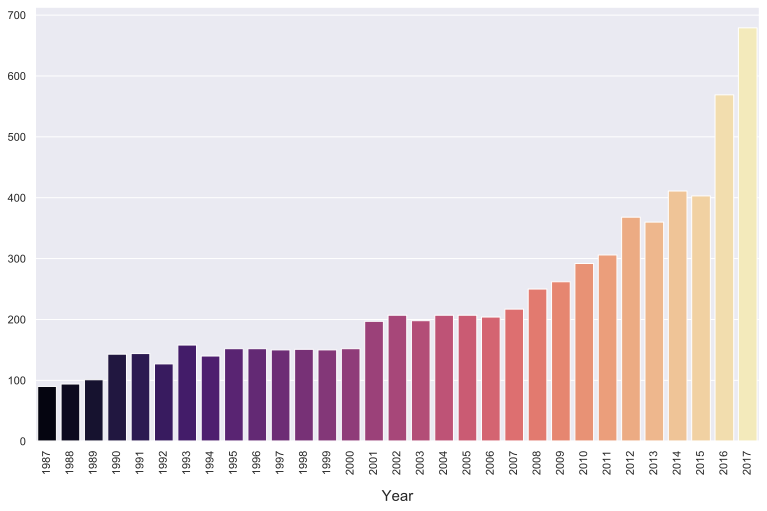

In [11]:
groups = dataset.groupby('year')
counts = groups.size()

plt.figure(figsize = (13, 8))
ax = sns.barplot(counts.index, counts.values, palette=("magma"))
ax.set_xlabel("Year",fontsize = 15, labelpad = 15)
plt.xticks(rotation = 90)
plt.show()

This graph shows how amount of papers are being accumulted over the years. Recent years have seen an increase in publication and it is a nice trend to consider for further analysis.

### 3.2)- Word count for text

In [12]:
#Fetch wordcount for each text document
dataset['w_count'] = dataset['paper_text'].apply(lambda x: len(str(x).split(" ")))
dataset[['paper_text','w_count']].head(10)

,paper_text,w_count
0,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,3315
1,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,2233
2,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,2727
3,Bayesian Query Construction for Neural\nNetwor...,2923
4,"Neural Network Ensembles, Cross\nValidation, a...",3009
5,U sing a neural net to instantiate a\ndeformab...,3335
6,Plasticity-Mediated Competitive Learning\n\nTe...,1659
7,ICEG Morphology Classification using an\nAnalo...,2470
8,Real-Time Control of a Tokamak Plasma\nUsing N...,2397
9,Real-Time Control of a Tokamak Plasma\nUsing N...,4283


In [13]:
dataset[['paper_text','w_count']].tail(10)

,paper_text,w_count
7231,695\n\nANALOG IMPLEMENTATION OF SHUNTING\nNEUR...,1749
7232,Comparing the prediction accuracy of\nartifici...,4561
7233,Stochastic Dynamics of Three-State\nNeural Net...,1673
7234,Grouping Components of\n?\nThree-Dimensional M...,1213
7235,Visual Speech Recognition with\nStochastic Net...,2391
7236,Single Transistor Learning Synapses\n\nPaul Ha...,2639
7237,"Bias, Variance and the Combination of\nLeast S...",3611
7238,A Real Time Clustering CMOS\nNeural Engine\nT....,2016
7239,Learning direction in global motion: two\nclas...,2818
7240,Correlation and Interpolation Networks for\nRe...,3075


In [14]:
##Descriptive statistics of word counts

dataset.w_count.describe()

count     7241.000000
mean      4259.252037
std       1237.864868
min          1.000000
25%       3211.000000
50%       4473.000000
75%       5194.000000
max      11519.000000
Name: w_count, dtype: float64

**Some insight from above:**

- Average word count in our text document is 4259 words per document. The word count ranges from a minimum of 1 word to maximum of 11519 words. This is useful information in a sense that it indicates size of dataset and also variation in word count across the rows

### 3.3)- Most common and uncommon words

A peek into the most common words gives insights not only on the frequently used words but also words that could also be potential data specific stop words. A comparison of the most common words and the default English stop words will give us a list of words that need to be added to a custom stop word list.

In [15]:
#Identify top 20 most common/frequently occuring words
common = pd.Series(' '.join(dataset['paper_text']).split()).value_counts()[:20]
common

the     1741341
of       992459
and      737835
?        643837
a        585149
to       565402
is       496162
in       472178
for      350809
that     291198
=        282147
,        226448
we       226390
with     223759
The      208088
on       193614
.        190768
by       184927
are      182535
as       181125
dtype: int64

Most of them are stop words and if we remove them then our data will be lighter. Also they are not contributing towards meaning of document so, removing them won't take away any useful information

In [16]:
#Identify top 20 uncommon words
uncommon=pd.Series(' '.join(dataset['paper_text']).split()).value_counts()[-20:]
uncommon

56.33                                  1
[A1].                                  1
-lo(~(.:it!-1                          1
(WVS):                                 1
-100.00                                1
O(N/N                                  1
95.62?0.83                             1
Legenstein1?,                          1
4.26)                                  1
0.8026                                 1
GPOMs                                  1
pa(k                                   1
Q7r(m,a)                               1
(D=2)                                  1
-17.59                                 1
object??).                             1
https://git.io/mmit-paper              1
x|x?n                                  1
proposed[1][2][3][4][5][6][10][11].    1
music/entertainment,                   1
dtype: int64

Some of these words are non-sense strings and we can drop them as well and there won't be any change in meaning of document.

# 4)- Text Preprocessing

- clean-up
- shrink vocab
- reduce sparsity

### 4.1)- Text cleaning

This is due to irrelevant words as we observed above. These additional and non-useful words contribute to noise in data and also data size is bigger.

So, we need to 

a)- Remove noise in text data(includes removal of stopwords, punctuation, tags,URLs, etc.) <br>
b)- Normalize text data(includes lemmatization or stemming)

In [17]:
# we shall use lemmatization for word normalization 

from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

In [18]:
# for noise removal

import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hassansherwani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
# for cleaning stopwords, we can use nltk default stopword list. Or we can add also more to this list

##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown",
             "fig","figure","image","sample","using", 
             "show", "result", "large", 
             "also", "one", "two", "three", 
             "four", "five", "seven","eight","nine"]
stop_words = list(stop_words.union(new_words))

In [20]:
# in previous excercise of spam/ham, I have worked over step by step cleaning process. Here, I'd do all in one 
#swift step for all documents in dataset. By the way, these documents collected are called "Corpus"

corpus = []
for i in range(0, 7241): # size of total documents within our dataset
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', dataset['paper_text'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

**For comparison between cleaned and uncleaned data**

In [21]:
# for original text data

unclean=dataset['paper_text']

In [22]:
unclean[941]

'Algorithms for Non-negative Matrix\nFactorization\n\nDaniel D. Lee*\n*BelJ Laboratories\nLucent Technologies\nMurray Hill, NJ 07974\n\nH. Sebastian Seung*t\ntDept. of Brain and Cog. Sci.\nMassachusetts Institute of Technology\nCambridge, MA 02138\n\nAbstract\nNon-negative matrix factorization (NMF) has previously been shown to\nbe a useful decomposition for multivariate data. Two different multiplicative algorithms for NMF are analyzed. They differ only slightly in\nthe multiplicative factor used in the update rules. One algorithm can be\nshown to minimize the conventional least squares error while the other\nminimizes the generalized Kullback-Leibler divergence. The monotonic\nconvergence of both algorithms can be proven using an auxiliary function analogous to that used for proving convergence of the ExpectationMaximization algorithm. The algorithms can also be interpreted as diagonally rescaled gradient descent, where the rescaling factor is optimally\nchosen to ensure convergence.

In [23]:
corpus[941]

'algorithm non negative matrix factorization daniel lee belj laboratory lucent technology murray hill nj h sebastian seung tdept brain cog sci massachusetts institute technology cambridge abstract non negative matrix factorization nmf useful decomposition multivariate data different multiplicative algorithm nmf analyzed differ slightly multiplicative factor used update rule algorithm minimize conventional least square error minimizes generalized kullback leibler divergence monotonic convergence algorithm proven auxiliary function analogous used proving convergence expectationmaximization algorithm algorithm interpreted diagonally rescaled gradient descent rescaling factor optimally chosen ensure convergence introduction unsupervised learning algorithm principal component analysis vector quantization understood factorizing data matrix subject different constraint depending upon constraint utilized resulting factor different representational property principal component analysis enforces

### 4.2)- Word Cloud Visualization

In [24]:
dataset['corpus']= corpus

In [25]:
dataset.head()

,id,year,title,abstract,paper_text,w_count,corpus
0,1,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,3315,self organization associative database applica...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,2233,mean field theory layer visual cortex applicat...
2,100,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,2727,storing covariance associative long term poten...
3,1000,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...,2923,bayesian query construction neural network mod...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a...",3009,neural network ensemble cross validation activ...


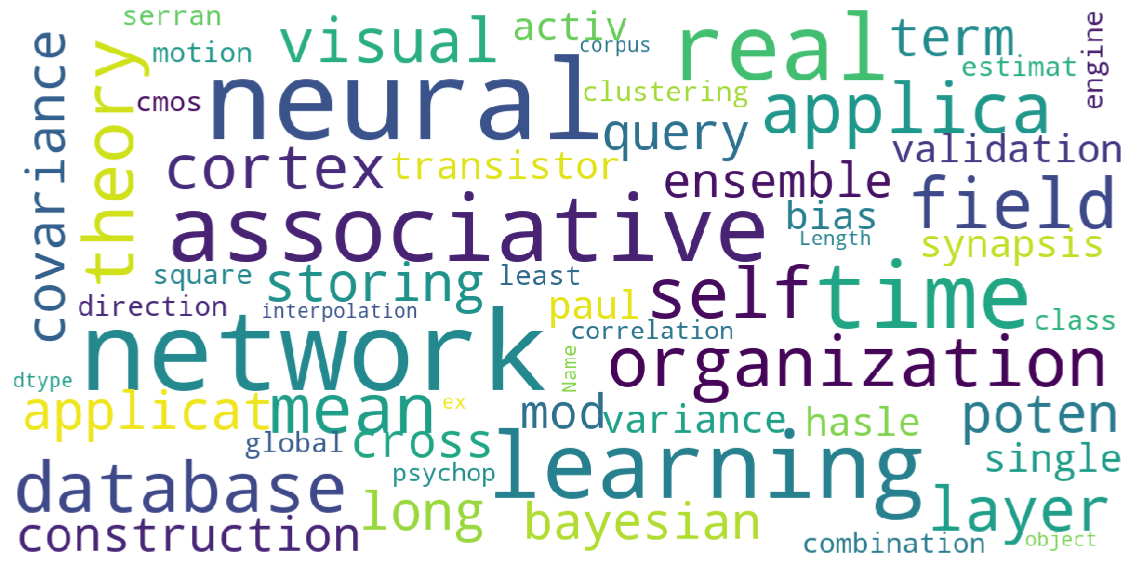

In [26]:
from wordcloud import WordCloud, STOPWORDS
stopwords=set(STOPWORDS)

def Mywordcloud (data, title=None):
    wordcloud=WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words= 100 ,
    max_font_size=40 ,
    scale=3,
    random_state=1
    ).generate(str(data))
    
    fig=plt.figure(1 , figsize(20, 20))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    
    plt.imshow(wordcloud)
    plt.show()
Mywordcloud(dataset['corpus'].dropna())

# 5)- Vectorization

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
import re

### 5.1)- Count Vectorizer

In [28]:
# don't forget to convert corpus to list if it's not
type(corpus)

list

In [29]:
# create vocabulary of words using bag of word model

cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus) # we do fit and transform in one instant

- **cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))**

- max_df — When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). This is to ensure that we only have words relevant to the context and not commonly used words.

- max_features — determines the number of columns in the matrix.

- n-gram range — we would want to look at a list of single words, two words (bi-grams) and three words (tri-gram) combinations.

In [30]:
X

<7241x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 5807024 stored elements in Compressed Sparse Row format>

In [31]:
X.shape

(7241, 10000)

In [32]:
type(X)

scipy.sparse.csr.csr_matrix

In [33]:
# An encoded vector is returned with a length of the entire vocabulary.

list(cv.vocabulary_.keys())[:10]

['self',
 'organization',
 'associative',
 'database',
 'application',
 'japan',
 'efficient',
 'organizing',
 'proposed',
 'together']

**Converting sparse to dense matrix**

A sparse matrix is a matrix that is comprised of mostly zero values. Sparse matrices are distinct from matrices with mostly non-zero values, which are referred to as dense matrices
if most of the elements are nonzero, then the matrix is considered dense.

In [34]:
X_bow=X.toarray()

In [35]:
type(X_bow)

numpy.ndarray

It is now in Document-term matrix form

In [36]:
bow_df = pd.DataFrame(X_bow, columns=cv.get_feature_names()) # see how we are converting to array instead of dataframe
bow_df.head()

,aa,aaai,aaron,ab,abbeel,abbott,abc,ability,able,able learn,...,zk,zl,zm,zn,zoubin,zoubin ghahramani,zp,zt,zt zt,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,2,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### 5.2)- Visualization 


using uni-gram, bi-gram, and tri-gram

#### 5.2.1)-Uni-gram

[Text(0, 0, 'model'),
 Text(0, 0, 'algorithm'),
 Text(0, 0, 'learning'),
 Text(0, 0, 'function'),
 Text(0, 0, 'data'),
 Text(0, 0, 'set'),
 Text(0, 0, 'network'),
 Text(0, 0, 'method'),
 Text(0, 0, 'problem'),
 Text(0, 0, 'time'),
 Text(0, 0, 'distribution'),
 Text(0, 0, 'number'),
 Text(0, 0, 'matrix'),
 Text(0, 0, 'value'),
 Text(0, 0, 'parameter'),
 Text(0, 0, 'feature'),
 Text(0, 0, 'training'),
 Text(0, 0, 'state'),
 Text(0, 0, 'result'),
 Text(0, 0, 'given')]

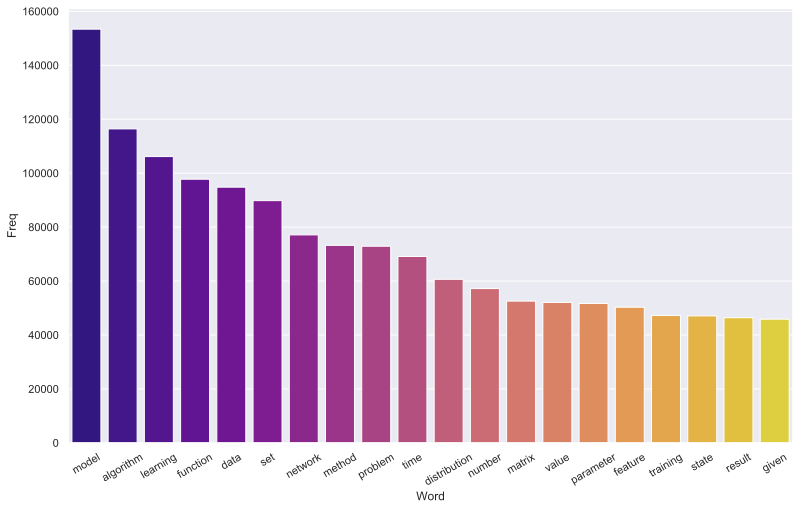

In [37]:
#Most frequently occuring uni-gram words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

#Bar plot of most frequent uni-grams
sns.set(rc={'figure.figsize':(13,8)})
g=sns.barplot(x="Word", y="Freq",palette=("plasma"), data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

#### 5.2.2)-Bi-gram

                     Bi-gram   Freq
0                      et al  20583
1             neural network  20087
2           machine learning  15768
3                   data set   9601
4     information processing   9585
5         neural information   9098
6          processing system   9044
7               training set   7651
8         learning algorithm   7215
9                lower bound   7110
10  international conference   6900
11            advance neural   6816
12             training data   5877
13             loss function   5741
14                   log log   5693
15      optimization problem   5592
16               upper bound   5552
17                data point   5446
18           random variable   5212
19    reinforcement learning   5170


[Text(0, 0, 'et al'),
 Text(0, 0, 'neural network'),
 Text(0, 0, 'machine learning'),
 Text(0, 0, 'data set'),
 Text(0, 0, 'information processing'),
 Text(0, 0, 'neural information'),
 Text(0, 0, 'processing system'),
 Text(0, 0, 'training set'),
 Text(0, 0, 'learning algorithm'),
 Text(0, 0, 'lower bound'),
 Text(0, 0, 'international conference'),
 Text(0, 0, 'advance neural'),
 Text(0, 0, 'training data'),
 Text(0, 0, 'loss function'),
 Text(0, 0, 'log log'),
 Text(0, 0, 'optimization problem'),
 Text(0, 0, 'upper bound'),
 Text(0, 0, 'data point'),
 Text(0, 0, 'random variable'),
 Text(0, 0, 'reinforcement learning')]

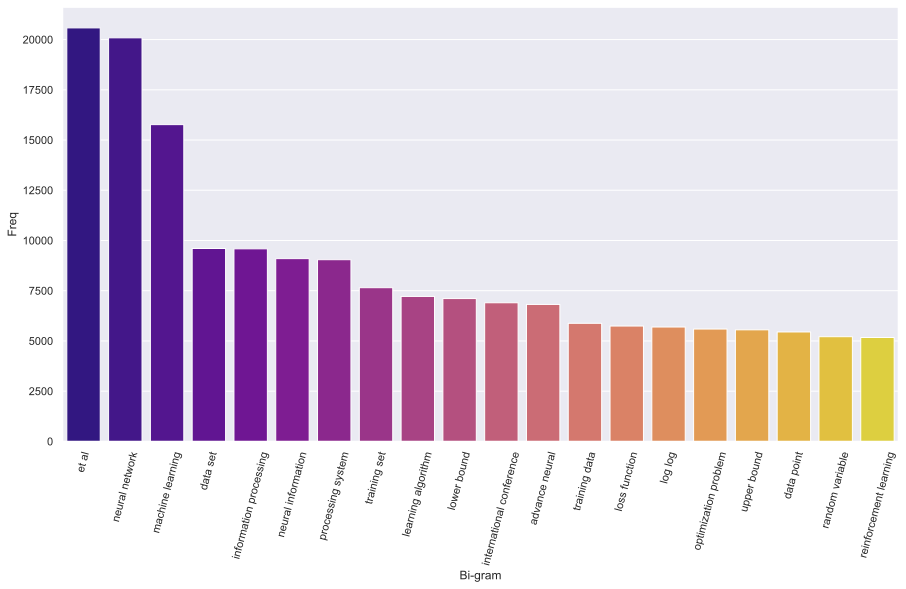

In [38]:
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

# for bi-gram

top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)

#Barplot of most freq Bi-grams

sns.set(rc={'figure.figsize':(15,8)})
h=sns.barplot(x="Bi-gram", y="Freq",palette=("plasma"), data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=75)

#### 5.2.3)-Tri-gram

                            Tri-gram  Freq
0      neural information processing  8996
1      information processing system  8851
2         advance neural information  6687
3               arxiv preprint arxiv  3621
4        conference machine learning  3544
5   international conference machine  3368
6          machine learning research  3220
7           journal machine learning  3077
8             processing system page  2644
9              processing system nip  2441
10            support vector machine  2364
11       th international conference  1615
12       department computer science  1535
13                       log log log  1519
14               hidden markov model  1504
15          recurrent neural network  1501
16       proceeding th international  1464
17     conference neural information  1452
18          semi supervised learning  1452
19       stochastic gradient descent  1383


[Text(0, 0, 'neural information processing'),
 Text(0, 0, 'information processing system'),
 Text(0, 0, 'advance neural information'),
 Text(0, 0, 'arxiv preprint arxiv'),
 Text(0, 0, 'conference machine learning'),
 Text(0, 0, 'international conference machine'),
 Text(0, 0, 'machine learning research'),
 Text(0, 0, 'journal machine learning'),
 Text(0, 0, 'processing system page'),
 Text(0, 0, 'processing system nip'),
 Text(0, 0, 'support vector machine'),
 Text(0, 0, 'th international conference'),
 Text(0, 0, 'department computer science'),
 Text(0, 0, 'log log log'),
 Text(0, 0, 'hidden markov model'),
 Text(0, 0, 'recurrent neural network'),
 Text(0, 0, 'proceeding th international'),
 Text(0, 0, 'conference neural information'),
 Text(0, 0, 'semi supervised learning'),
 Text(0, 0, 'stochastic gradient descent')]

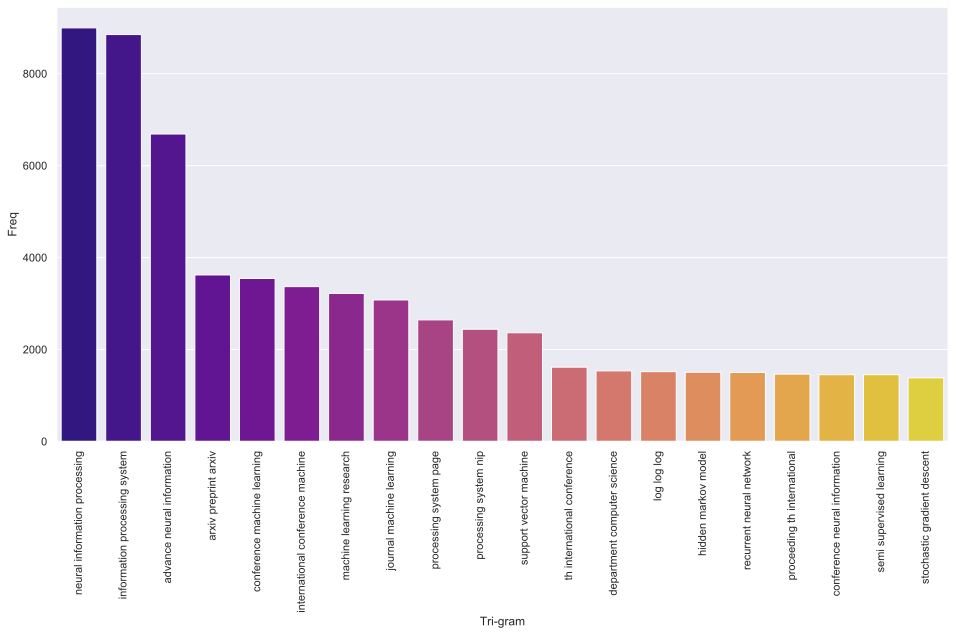

In [39]:
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

# for tri-gram
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)

#Barplot of most freq Tri-grams
sns.set(rc={'figure.figsize':(16,8)})
j=sns.barplot(x="Tri-gram", y="Freq",palette=("plasma"), data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=90)

# 6)- TF-IDF

Converting corpus to a matrix of integer

In [41]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [42]:
# get feature names
feature_names=cv.get_feature_names()

In [43]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

# A function to get keywords

def get_keywords(idx, docs):

    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([docs[idx]]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    
    return keywords

def print_results(idx,keywords, df):
    # now print the results
    print("\n=====Title=====")
    print(dataset['title'][idx])
    print("\n=====Abstract=====")
    print(dataset['abstract'][idx])
    print("\n===Keywords===")
    for k in keywords:
        print(k,keywords[k])

In [44]:
# pick one document out of data

idx=941 # one we used earlier
keywords=get_keywords(idx, corpus)
print_results(idx,keywords,dataset)


=====Title=====
Algorithms for Non-negative Matrix Factorization

=====Abstract=====
Non-negative matrix factorization (NMF) has previously been shown to 
be a useful decomposition for multivariate data. Two different multi- 
plicative algorithms for NMF are analyzed. They differ only slightly in 
the multiplicative factor used in the update rules. One algorithm can be 
shown to minimize the conventional least squares error while the other 
minimizes the generalized Kullback-Leibler divergence. The monotonic 
convergence of both algorithms can be proven using an auxiliary func- 
tion analogous to that used for proving convergence of the Expectation- 
Maximization algorithm. The algorithms can also be interpreted as diag- 
onally rescaled gradient descent, where the rescaling factor is optimally 
chosen to ensure convergence. 

===Keywords===
ht 0.637
ht ht 0.304
update rule 0.235
update 0.195
auxiliary 0.145
non negative matrix 0.144
negative matrix 0.143
rule 0.131
ub 0.13
nmf 0.125


In [45]:
idx=20 # one we used earlier
keywords=get_keywords(idx, corpus)
print_results(idx,keywords,dataset)


=====Title=====
Connectionist Speaker Normalization with Generalized Resource Allocating Networks

=====Abstract=====
Abstract Missing

===Keywords===
speaker 0.708
normalization 0.22
utterance 0.186
acoustic 0.184
recognition system 0.16
speech 0.158
recognition 0.149
phone 0.126
spectral 0.126
female 0.113


So while researchers or scientists do invest so much for reading a document, it is wise to create an automated method which could identify keywords of that document like most of scientific journals do.